# NFPA-CBA Example 1 : Single-family dwelling (RES1)

## Notebook initialization

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

from export import get_xlsx
from graphs import graph_indirect_cost, graph_cost_distribution

get_xlsx()

## Introduction
This Notebook presents an example application of the prototype methodology for cost-benefit analysis. This case study considers a single-family dwelling. The benefit of sprinkler installation is investigated. The building is adapted from (Butry, 2009). For background on the model and considered input values, see the background document.

The benefit of the sprinkler system relies on an evaluation of the expected cost of fire damages (i) without sprinkler protection, and (ii) with sprinkler protection. The event tree defining the different damage scenarios for the design is visualized below.

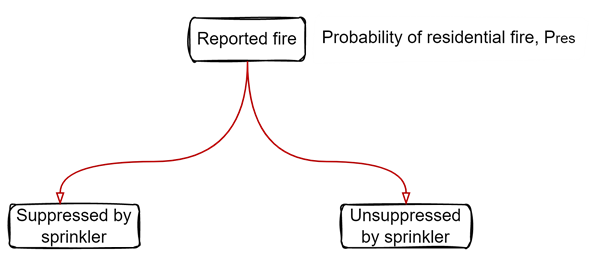

## I. Input
User input in this area.  
Note: All monetary values in 2022 USD.  

In [2]:

# I.1 Building characteristics. Case derived from second example dwelling in Butry (2009). Building area is 2257 ft2 (210 m2). Two stories considered.
structure_area = 210 # [m2] Floor area of structure
construction_cost = 1305.54 # [USD/m2] Construction cost; 1305.54 evaluated through (RSMeans, 2022), including dectector cost
demolition_cost = 33.53 # [USD/m2] Demolition cost; 33.53 evaluated through (RSMeans, 2022)
disposal_cost = 14.43 # [USD/m2] Disposal cost; 14.43 evaluated through (RSMeans, 2022)

# I.2 Discount rate and obsolescence rate
discount_rate = 0.03 # [1/year] continuous discount rate; 3% based on (Fischer, 2014)
obsolescence_rate = 0    # [1/year] obsolescence rate; 0% - building obsolescence neglected

# I.3 Cost of fire protection
sprinkler_installation_cost= 11.68 # [USD/m2] System installation cost; 11.68 for sprinkler installation including water supply for wet pipe sprinkler system evaluated through (RSMeans, 2022)
sprinkler_installation_cost_total = sprinkler_installation_cost * structure_area # [USD] Total system installation cost

# I.3.b Maintenance cost fire protection
maintenance_cost = 0.05 * sprinkler_installation_cost_total  # [USD per year] annual maintenance cost; 5% of sprinkler installation cost based on (Hopkin, 2019) - maintenance cost assumed to include replacement of parts for system lifetime extension

# I.4 Benefit of fire protection. Benefit evaluation as reduction in cost of fire losses, assessed through flowchart listed in the Introduction. See background document for discussion.

# I.4.a Fire frequency
fire_frequency = 0.00151 # [1/year] fire frequency per dwelling (ignition frequency + unsuccesful immediate suppression by occupants); 0.00151 based on (Manes and Rush, 2019) 

# 1.4.b Sprinkler reliability
prob_fire_suppression = 0.95 # [-] probability of succesful fire suppression by sprinklers; 0.92-0.98 based on (Vassart et al., 2014)

# I.4.c Fire-induced losses

## I.4.c.1 valuation of risk to life
value_of_statistical_life = 5.657*10**6 # [2022 USD] Value of Statistical Life (VSL); 5.657*10**6 based on (ISO 2394:2015) 
value_avg_injury = (0.047 * value_of_statistical_life) # [2022 USD] valuation of average injury risk; 0.047*VSL based on (Zhuang et al., 2017)

## I.4.c.2 fatalities/fire
prob_civilian_fatality = 7.4/1000 # [fatality/fire] probability of civilian fatalities; 7.4 fatalities per 1000 residential fires based on (NFPA 2022)
prob_firefighter_fatality_ground = 2.4/1e5 # [fatality/fire] probability of firefighter fireground fatality; 2.4/1e5 based on (NFPA, 2022)
prob_firefighter_fatality_response = 2.2/1e5 # [fatality/fire] probability of firefighter response fatality; 2.2/1e5 based on (NFPA, 2022)

## I.4.c.3 injuries/fire
civilian_injuries_per_fire = 3/100 # [injury/fire] civilian injuries; 3 injuries per 100 reported fires based on (NFPA, 2022)
firefighter_injuries_ground_per_fire = 1.62/100 # [injury/fire] firefighter fireground injuries; 1.62 injuries per 100 reported fires based on (NFPA, 2022)
firefighter_injuries_response_per_fire = 0.37/100 # [injury/fire] firefighter response injuries; 0.37 injuries per 100 reported fires based on (NFPA, 2022)

## I.4.c.4 property loss
sprinkler_damage_0 = 35.69 # [m2] average damage area in case of sprinkler suppression; 35.69 based on (Manes and Rush, 2019)
sprinkler_damage_s = 4.92 # [m2] average damage area in case of sprinkler suppression; 4.92 based on (Manes and Rush, 2019)
multiply_property_loss = 1.5 # [-] property loss multiplication factor; eps_loss = ((building loss + content loss) / building loss); 1.5 based on (FEMA, 2015)
multiply_indirect_loss = 1.1 # [-] total property loss multiplication factor accounting for indirect costs; 1.1 based on (Ramachandran, 1998)

## II. Design fire risk evaluation

### II.1 Calculation of fire scenario parameters
Input parameter calculation from raw input data.

In [3]:
replacement_cost = construction_cost + demolition_cost + disposal_cost # [USD/m2] replacement cost as sum of demolition, disposal and reconstruction

### II.2 Scenario consequence evaluation
Evaluation of consequences for identified scenarios (event tree)

#### II.2.a Scenario "no sprinkler suppression"

In [4]:
### Fatalities and injuries
inherent_fatality_per_fire = prob_civilian_fatality + prob_firefighter_fatality_ground + prob_firefighter_fatality_response # [fatality/fire] total fatality rate without sprinkler suppression
inherent_injury_per_fire = civilian_injuries_per_fire + firefighter_injuries_ground_per_fire + firefighter_injuries_response_per_fire  # [injury/fire] total injury rate without sprinkler suppression

In [5]:
### Valuation of fatalities and injuries
inherent_fatality_cost_no_sprinkler = inherent_fatality_per_fire * value_of_statistical_life # [USD/fire] valuation expected life loss
inherent_injury_cost_no_sprinkler = inherent_injury_per_fire * value_avg_injury # [USD/fire] valuation expected injuries

In [6]:
### Material loss
inherent_property_loss = sprinkler_damage_0 * replacement_cost * multiply_property_loss * multiply_indirect_loss # [USD] property loss

In [7]:
### Total loss valuation
inherent_total_cost = inherent_fatality_cost_no_sprinkler + inherent_injury_cost_no_sprinkler + inherent_property_loss # expected value fire-induced loss, scenario "no sprinkler suppression"

#### II.2.b Scenario "successful sprinkler suppression"

In [8]:
### Fatalities and injuries

# injury rate and valuation
# reduction in civilian injuries in case of succesful sprinkler suppression, based on (Butry, 2009)
# only fire fighter response fatalities considered [comment Alex: is this correct?]
reduction_civilian_injuries = 0.57 # [-] reduction factor for civilian injuries; 57% reduction in civilian injuries, based on (Butry, 2009)
total_injury_rate_with_sprinkler = (1 - reduction_civilian_injuries) * civilian_injuries_per_fire + firefighter_injuries_response_per_fire # [injury/fire] total injury rate in case of sprinkler suppression

In [9]:
### Valuation of fatalities and injuries
# fatality valuation
# no fire-induced fatalities in case of succesful sprinkler suppression, based on (Butry, 2009); 
# only fire fighter response fatalities considered
residual_fatality_cost = prob_firefighter_fatality_response * value_of_statistical_life # [USD/fire] valuation expected life loss
# injury valuation
residual_injury_cost = total_injury_rate_with_sprinkler * value_avg_injury # [USD/fire] valuation expected injuries

In [10]:
### Material loss
residual_property_loss = sprinkler_damage_s * replacement_cost * multiply_property_loss * multiply_indirect_loss # [USD/fire] property loss given fire in case of succesful sprinkler suppression

In [11]:
### Total loss valuation
residual_total_cost = residual_fatality_cost + residual_injury_cost + residual_property_loss # [USD/fire] expected value fire-induced loss, scenario "successful sprinkler suppression"

## III. PNV calculation

### III.1 Total safety system cost *C+A*

In [12]:
pnv_investment_cost = sprinkler_installation_cost_total # PNV investment cost
pnv_maintenance_cost = maintenance_cost / discount_rate # PNV of maintenace cost
pnv_obsolescence_cost = pnv_investment_cost * obsolescence_rate / discount_rate # PNV of obsolescence cost

# Total safety system cost
pnv_total_investment_cost = pnv_investment_cost + pnv_maintenance_cost + pnv_obsolescence_cost # total PNV investment cost (investment cost and maintenance cost)

### III.2 Net benefit *B-D*

#### III.2.a Fire-induced losses reference design, *B*
Reference design without sprinkler protection. Single scenario in event tree: scenario "no sprinkler suppression".

In [13]:
## Expected loss reference design
reference_design_cost = inherent_total_cost # [USD/fire]

## PNV reference design
pnv_reference_design_cost = reference_design_cost * fire_frequency / discount_rate # [USD] PNV fire-induced losses reference design

#### III.2.b Fire-induced losses trial design, *D*
The trial design considers the additional safety feature of a sprinkler system.  
The sprinkler system has a reliability prob_fire_suppression.  
The overall design performance is a combination of the scenario "no sprinkler suppression" (with probability 1-prob_fire_suppression) and the scenario "successful sprinkler suppression" (with probability prob_fire_suppression).

In [14]:
## Expected loss design with sprinkler protection
trial_design_cost = (1 - prob_fire_suppression) * inherent_total_cost + prob_fire_suppression * residual_total_cost # [USD/fire]

## PNV reference design [comment Alex: is this correct? Shouldn't it be PNV trial design?]
pnv_trial_design = trial_design_cost * fire_frequency / discount_rate # [USD] PNV expected risk to life reference design

# PNV net benefit
pnv_net_benefit = pnv_reference_design_cost - pnv_trial_design # [USD] PNV net benefit

## IV. Cost-Benefit evaluation

In [15]:
benefit_cost_ratio = pnv_net_benefit / pnv_total_investment_cost # [-] benefit cost ratio
cost_benefit_ratio = 1 / benefit_cost_ratio
pnv_proposed_safety_measure = pnv_net_benefit - pnv_total_investment_cost # [USD] PNV of proposed safety measure

print(f"BCR = {benefit_cost_ratio:.2f}")
print(f"CBR = {cost_benefit_ratio:.2f}")
print(f"PNV = {pnv_proposed_safety_measure:.0f} [USD]")
print(pnv_net_benefit)

BCR = 0.87
CBR = 1.14
PNV = -823 [USD]
5717.401079684167


# Example 1 - Parameter study and visualizations

### Visualization of cost distribution design alternatives

In [16]:
### Design alternatives- With and without sprinklers

## Investment costs
investment_sprinkler = np.array([sprinkler_installation_cost_total, pnv_maintenance_cost, pnv_obsolescence_cost]) # [USD] array of PNV investment costs for case without sprinklers (investment, maintenance, obsolescence)
investment_no_sprinkler = np.array([0,0,0]) # [USD] array of PNV investment costs for case without sprinklers (investment, maintenance, obsolescence)

### Two scenarios (Fire suppressed by sprinkler and unsuppressed by sprinkler)
## Scenario unsuppressed by sprinklers
# valuation of risk to life
inherent_fatality_cost_no_sprinkler = inherent_fatality_per_fire * value_of_statistical_life # [USD/fire] valuation expected life loss
inherent_injury_cost_no_sprinkler = inherent_injury_per_fire * value_avg_injury # [USD/fire] valuation expected injuries

# valuation of material losses
inherent_property_building_loss = sprinkler_damage_0 * replacement_cost # [USD] direct property loss related to the building itself
inherent_property_contents_loss = inherent_property_building_loss * (multiply_property_loss - 1) # [USD] direct property loss related to the contents
inherent_property_indirect_loss = inherent_property_building_loss * multiply_property_loss * (multiply_indirect_loss - 1) # indirect losses

# Array of costs and PNV evaluation
inherent_costs = np.array([inherent_property_building_loss, inherent_property_contents_loss, inherent_property_indirect_loss, inherent_fatality_cost_no_sprinkler, inherent_injury_cost_no_sprinkler])
inherent_costs = inherent_costs * fire_frequency / discount_rate

## Scenario suppressed by sprinklers
# valuation of risk to life
residual_fatality_cost = prob_firefighter_fatality_response * value_of_statistical_life # [USD/fire] valuation expected life loss
residual_injury_cost = total_injury_rate_with_sprinkler * value_avg_injury # [USD/fire] valuation expected injuries

# valuation of material losses
residual_property_loss = sprinkler_damage_s * replacement_cost # [USD] direct property loss related to the building itself
residual_content_loss = residual_property_loss * (multiply_property_loss - 1) # [USD] direct property loss related to the contents
residual_indirect_loss = residual_property_loss * (multiply_property_loss) * (multiply_indirect_loss - 1) # indirect losses

# Array of costs and PNV evaluation
residual_costs = np.array([
    residual_property_loss,
    residual_content_loss,
    residual_indirect_loss,
    residual_fatality_cost,
    residual_injury_cost
])
residual_costs = residual_costs * fire_frequency / discount_rate

### Costs per design
## Design A, no sprinkler system,
prob_fire_suppression_no_sprinkler = 0 # No sprinkler system present
costs_no_sprinkler = (1 - prob_fire_suppression_no_sprinkler) * inherent_costs + prob_fire_suppression_no_sprinkler * residual_costs
total_cost_no_sprinkler = np.append(costs_no_sprinkler, investment_no_sprinkler)

## Design B, with sprinkler system
costs_sprinkler = (1 - prob_fire_suppression) * inherent_costs + prob_fire_suppression * residual_costs
total_cost_sprinkler = np.append(costs_sprinkler, investment_sprinkler)

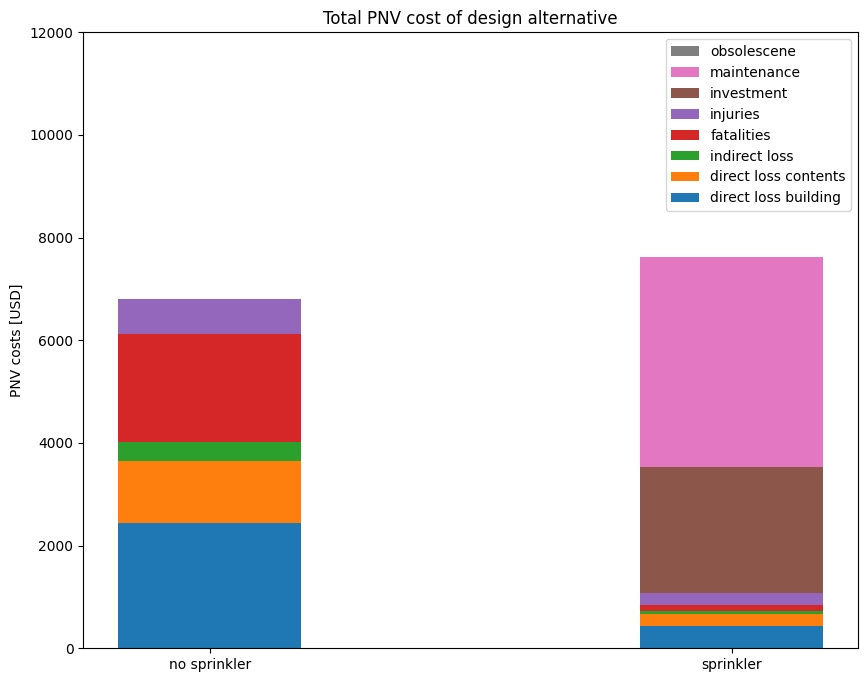

In [17]:
### Visualization of cost distribution per design
fig = graph_cost_distribution(total_cost_no_sprinkler, total_cost_sprinkler)
plt.show()

### Parameter study with VSL and efficiency of sprinkler system

#### Function definition PNV Z, to allow parameter study VSL,psup_sp and eps_loss_indirect

In [18]:
# Function combining above model assumption for parameter study

def Zvalue(VSL, psup_sp, eps_loss_indirect):
    ## I. Input ##
    ##############
    ## I.4.c Fire-induced losses
    avg_injury_risk_cost = (0.047 * VSL) # [2021 USD] valuation of average injury risk; 0.047*VSL based on (Zhuang et al., 2017)

    ## II. Design fire risk evaluation ##
    #####################################    
    ## II.2.a Scenario "no sprinkler suppression"
    ### Valuation of fatalities and injuries
    Df_0 = inherent_fatality_per_fire * VSL # [USD/fire] valuation expected life loss
    Din_0 = inherent_injury_per_fire * avg_injury_risk_cost # [USD/fire] valuation expected injuries
    ### Material loss
    xi_d_0= sprinkler_damage_0 * replacement_cost * multiply_property_loss * eps_loss_indirect # [USD] property loss
    ### Total loss valuation
    D0=Df_0+Din_0+xi_d_0 # expected value fire-induced loss, scenario "no sprinkler suppression"

    ## II.2.b Scenario "successful sprinkler suppression"
    ### Valuation of fatalities and injuries
    Df_s=prob_firefighter_fatality_response*VSL # [USD/fire] valuation expected life loss
    Din_s=total_injury_rate_with_sprinkler*avg_injury_risk_cost # [USD/fire] valuation expected injuries
    ### Material loss
    xi_d_s= sprinkler_damage_s * replacement_cost * multiply_property_loss * eps_loss_indirect # [USD/fire] property loss given fire in case of succesful sprinkler suppression
    ### Total loss valuation
    Dsup=Df_s+Din_s+xi_d_s # [USD/fire] expected value fire-induced loss, scenario "successful sprinkler suppression"

    ## III. PNV calculation ##
    ##########################
    ## III.2.a Fire-induced losses reference design, B
    ## Expected loss reference design
    Dref=D0 # [USD/fire]
    ## PNV reference design
    B=Dref*fire_frequency/discount_rate # [USD] PNV fire-induced losses reference design

    ## III.2.b Fire-induced losses trial design, D
    ## Expected loss design with sprinkler protection
    Dsp=(1-psup_sp)*D0+psup_sp*Dsup # [USD/fire]
    ## PNV reference design
    D=Dsp*fire_frequency/discount_rate # [USD] PNV expected risk to life reference design

    ## III.2.c PNV net benefit, B-D
    netB=B-D # [USD] PNV net benefit

    ## IV. Cost-Benefit evaluation ##
    #################################
    Z=netB-pnv_total_investment_cost # [USD] PNV of proposed safety measure

    return Z

#### Example of usage function Zvalue

In [19]:
## Example application of function Zvalue - verification base values

# input values
multiply_indirect_property_loss = 1.1 # [-] total property loss multiplication factor accounting for indirect costs; 1.1 based on (Ramachandran, 1998)

# CBA 
pnv_proposed_safety_measure = Zvalue(value_of_statistical_life, prob_fire_suppression, multiply_indirect_property_loss) # [USD] PNV of proposed safety measure
print("The PNV is {0:.0f} [USD]".format(pnv_proposed_safety_measure))

The PNV is -823 [USD]


#### Parameter study and visualization

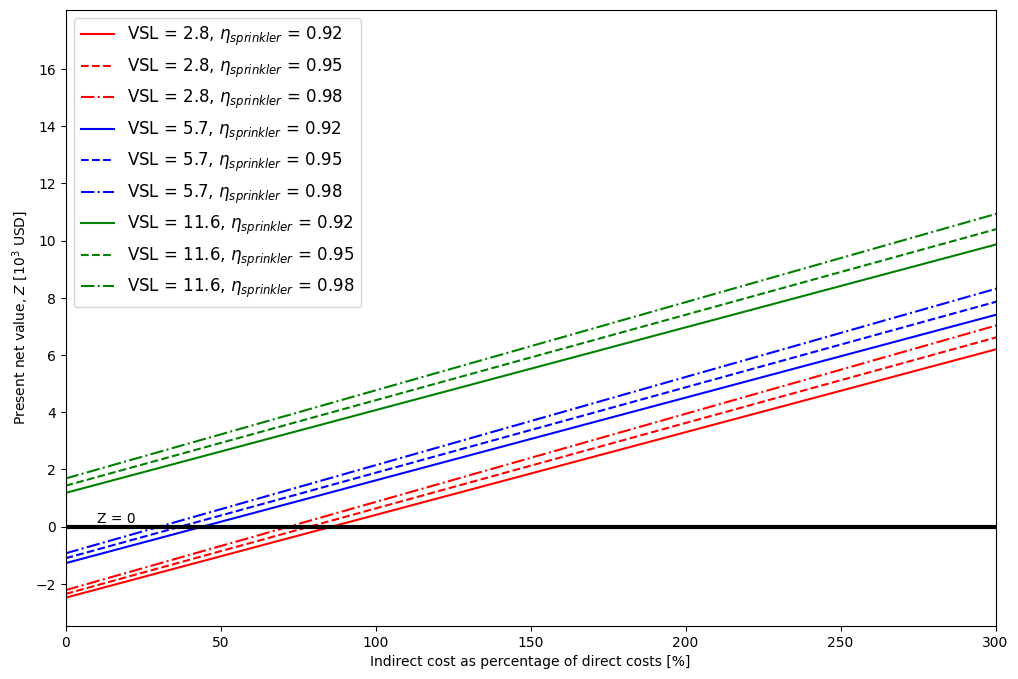

In [20]:
VSLs = np.array([2.8, 5.7, 11.6]) * 1e+6 # [USD]; note: 11.6 USD listed by (Department of Transportation, 2011)
eta_sprinkler = np.array([0.92,0.95,0.98])
indirect_cost = np.array([0,2,5,10,20,50,100,200,300,400,500])

nCases = len(VSLs) * len(eta_sprinkler)

m_eta_sprinkler, m_VSL = np.meshgrid(eta_sprinkler,VSLs)
m_VSL = m_VSL.ravel()
m_eta_sprinkler = m_eta_sprinkler.ravel()

m_Z = np.zeros((len(indirect_cost),len(m_VSL)))

for num in np.arange(len(m_VSL)):
    m_Z[:,num] = Zvalue(m_VSL[num], m_eta_sprinkler[num], 1 + indirect_cost / 100)

# Plot the data
fig = graph_indirect_cost(m_VSL, indirect_cost, m_Z, m_eta_sprinkler)
plt.show()